In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdmolops, AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'


In [2]:
df = pd.read_csv('./raw/atom_number_wH_sort_1115-backbone-correction-newSMILES.csv')
df

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No,HOMO(eV),LUMO(eV)
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10,-5.20,-3.27
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123,-4.90,-3.08
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126,-5.34,-3.58
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122,-5.15,-3.23
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122,-5.11,-3.22
...,...,...,...,...,...,...,...
1110,BTT-NTz,1.68,CCCCCCCCCCCCc1cc(C)sc1-c1cc2c3sc(C(CCCCCCCC)CC...,Cc1cc(C)c(s1)-c1cc2c3sc(C)cc3c3cc(sc3c2s1)-c1s...,S115,-5.41,-3.73
1111,PIDTI-BT,1.65,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1cc2n(C)c3cc4-c5cc6c(cc5C(c4cc3c2s1)(c1ccccc...,S441,-5.30,-3.65
1112,PIDTI-DTBT,1.66,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1ccc(s1)-c1ccc(-c2ccc(s2)-c2cc3n(C)c4cc5-c6c...,S441,-5.26,-3.60
1113,poly(DPP4T-alt-TBP),1.52,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)C2=C(c3ccc(-c...,CN1C(=O)C2=C(N(C)C(=O)C2=C1c1ccc(C)s1)c1ccc(s1...,S464,-5.42,-3.90


# drop sp3-N polymers + donor-692

In [3]:
sp3_N_list = [  24,   44,  191,  201,  206,  209,  251,  317,  318,  332,  374,
             381,  388,  454,  913,  931,  936, 1006]
drop_list = sp3_N_list+[691]
print('Total data points: ', 1115-len(drop_list))

Total data points:  1096


In [4]:
df = df[~df.index.isin(drop_list)].reset_index(drop=True)
df.shape

(1096, 7)

In [5]:
df

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No,HOMO(eV),LUMO(eV)
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10,-5.20,-3.27
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123,-4.90,-3.08
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126,-5.34,-3.58
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122,-5.15,-3.23
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122,-5.11,-3.22
...,...,...,...,...,...,...,...
1091,BTT-NTz,1.68,CCCCCCCCCCCCc1cc(C)sc1-c1cc2c3sc(C(CCCCCCCC)CC...,Cc1cc(C)c(s1)-c1cc2c3sc(C)cc3c3cc(sc3c2s1)-c1s...,S115,-5.41,-3.73
1092,PIDTI-BT,1.65,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1cc2n(C)c3cc4-c5cc6c(cc5C(c4cc3c2s1)(c1ccccc...,S441,-5.30,-3.65
1093,PIDTI-DTBT,1.66,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1ccc(s1)-c1ccc(-c2ccc(s2)-c2cc3n(C)c4cc5-c6c...,S441,-5.26,-3.60
1094,poly(DPP4T-alt-TBP),1.52,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)C2=C(c3ccc(-c...,CN1C(=O)C2=C(N(C)C(=O)C2=C1c1ccc(C)s1)c1ccc(s1...,S464,-5.42,-3.90


In [6]:
df.describe()

,bandgap(eV),HOMO(eV),LUMO(eV)
count,1096.000000,1096.000000,1096.000000
mean,1.715839,-5.333759,-3.617920
std,0.205823,0.224913,0.256235
min,1.000000,-6.180000,-4.600000
25%,1.590000,-5.470000,-3.780000
50%,1.710000,-5.340000,-3.620000
75%,1.830000,-5.200000,-3.460000
max,2.390000,-4.240000,-2.590000


In [7]:
def hist_plot(data, label, xticks, yticks, xlabel, yscale):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    xmax=data[label].max()
    xmin=data[label].min()
    interval=(xmax-xmin)/70.
    n, bins, patches = plt.hist(data[label], bins=np.arange(xmin,xmax,interval)
                                , color='#809bce'
                                , edgecolor='black', linewidth=1.5, density = False )
    ax.tick_params(direction='in', width=2)
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        
    plt.xlabel(xlabel, fontsize=38, font="arial", labelpad=12)
    plt.ylabel('Count', fontsize=38, font="arial", labelpad=12)
    plt.xticks(xticks, fontsize=26)
    plt.yticks(yticks, fontsize=26)
    plt.gca().tick_params(axis='both', length=10, width=2)

#     plt.xlim(xscale[0], xscale[1])
    plt.ylim(yscale[0], yscale[1])
    plt.show()


# 1. HOMO

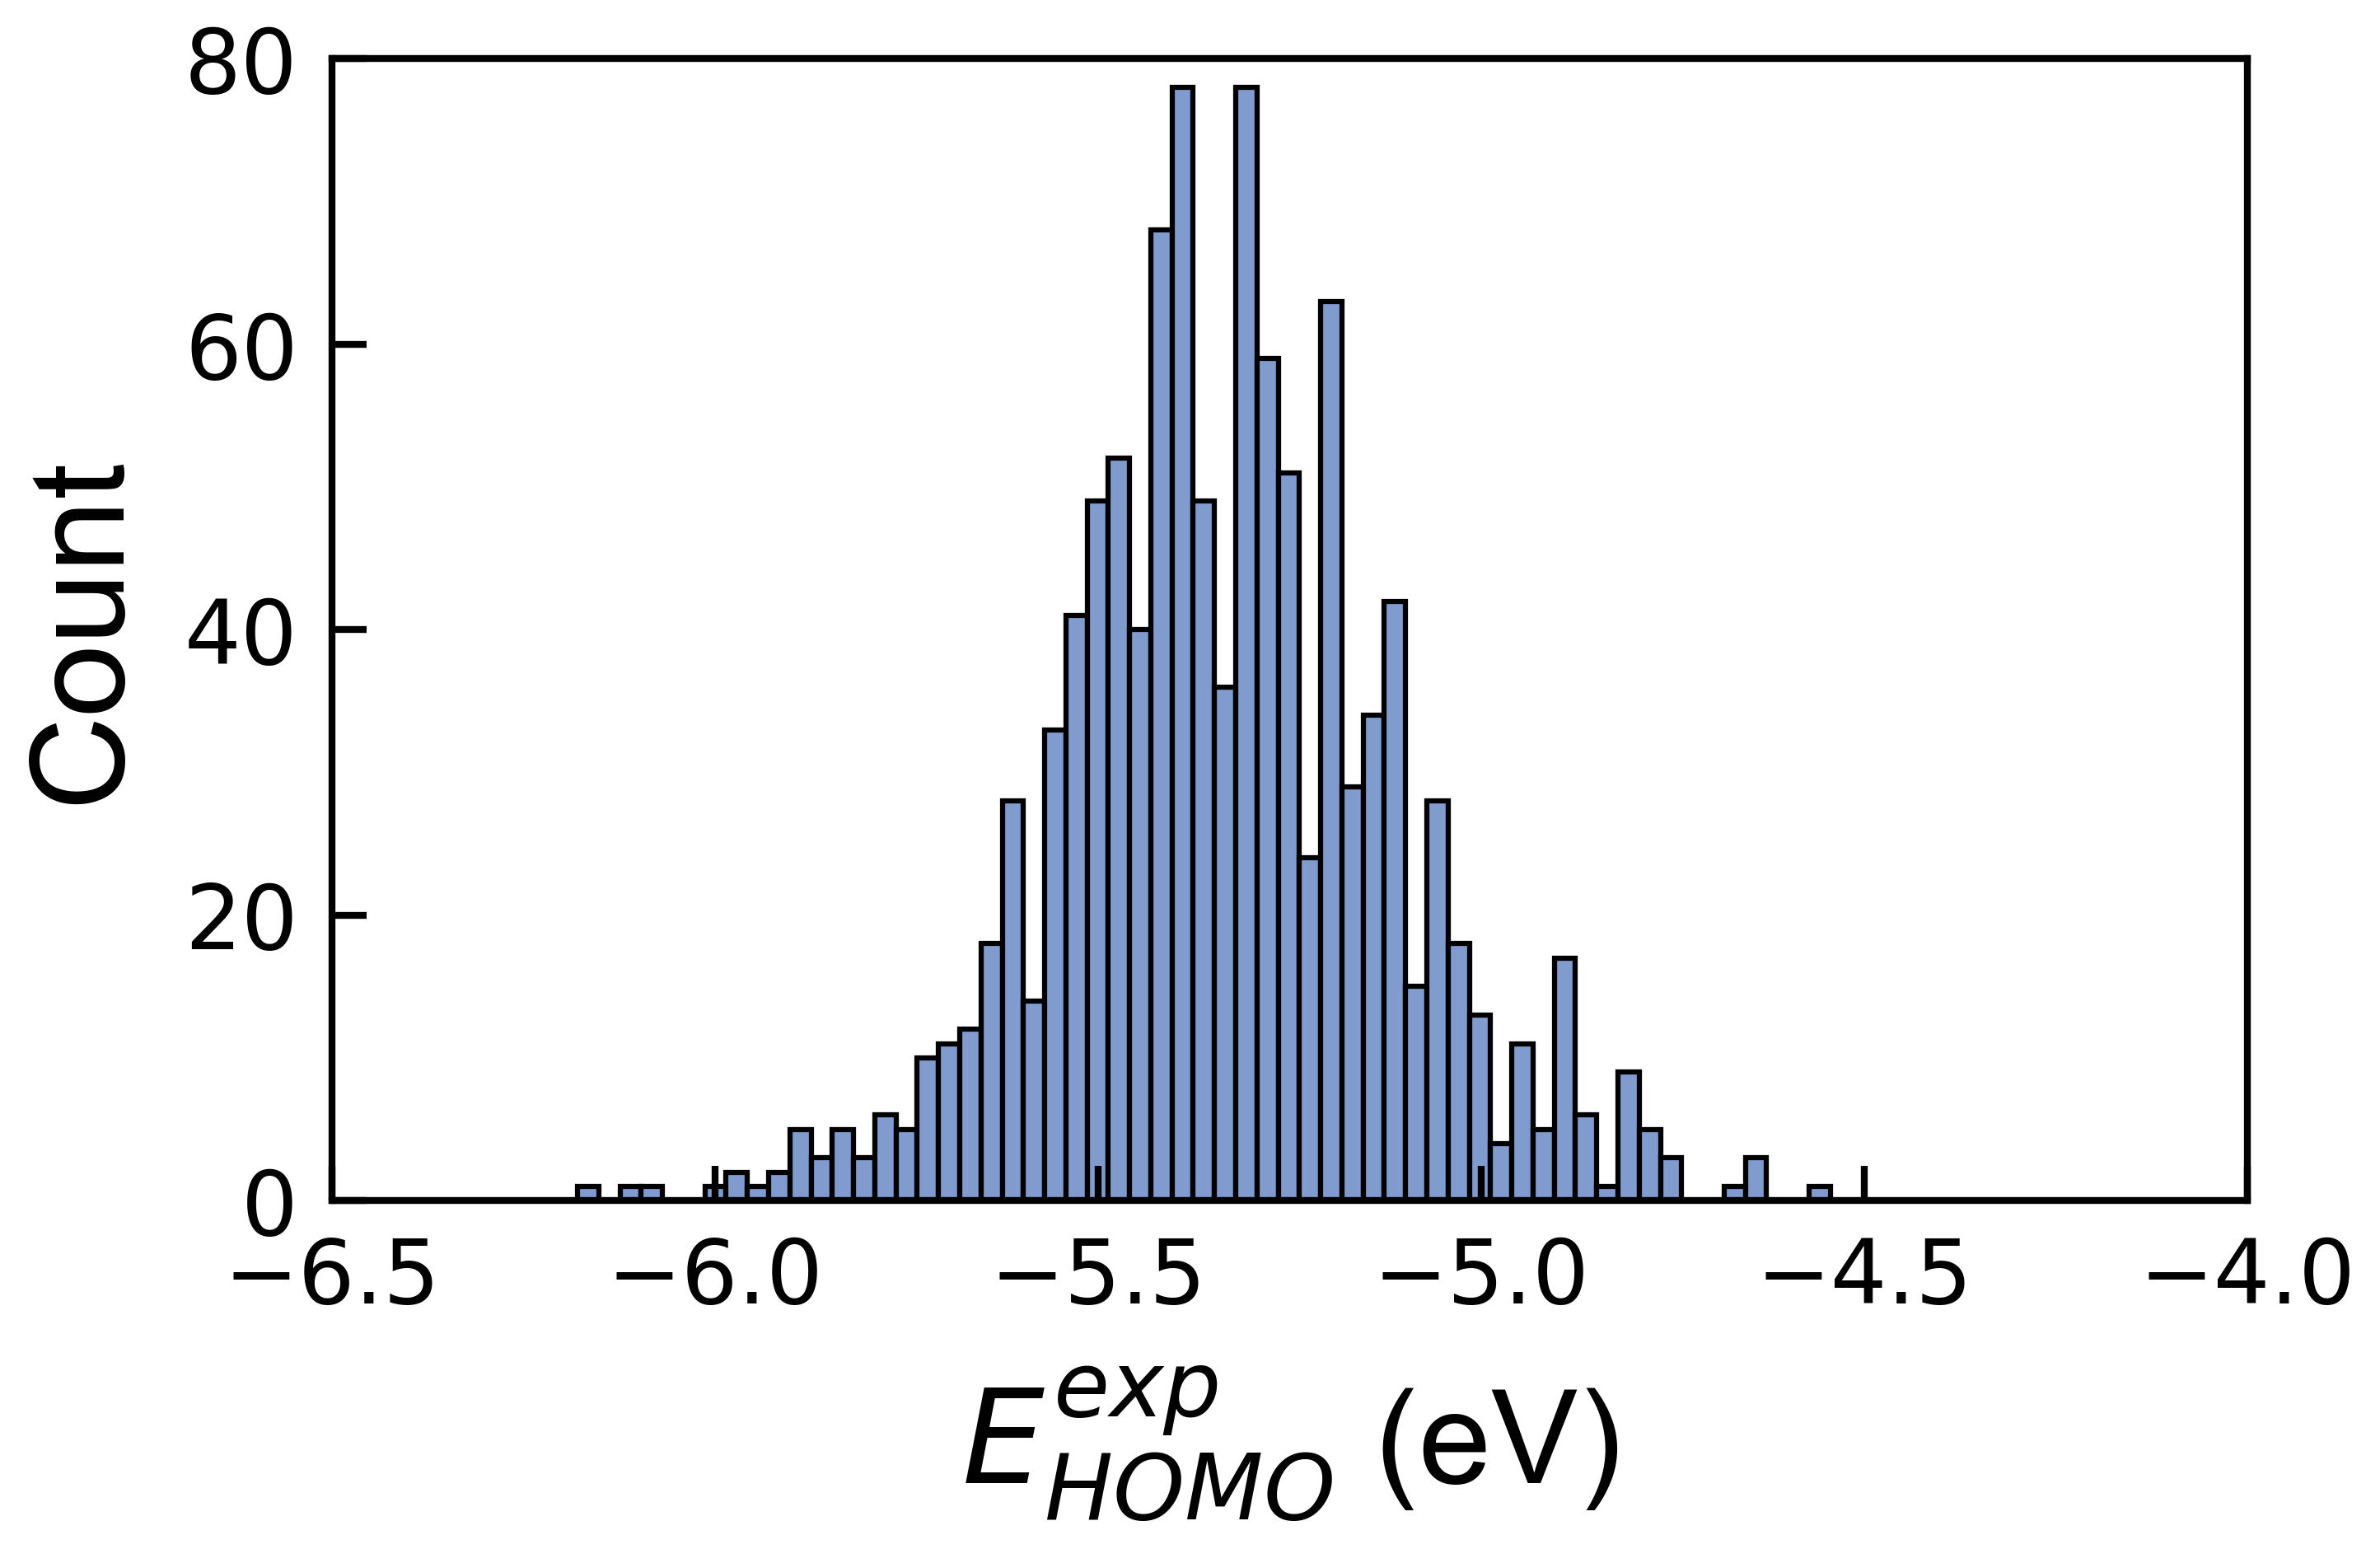

In [8]:
xticks=[-6.5,-6, -5.5, -5, -4.5,-4]
yticks = [0, 20, 40, 60, 80]
yscale =[0, 80]
xlabel='$E_{HOMO}^{exp}$ (eV)'
hist_plot(df, 'HOMO(eV)', xticks, yticks, xlabel, yscale)

In [9]:
print('80% range:',df['HOMO(eV)'].quantile(0.1), df['HOMO(eV)'].quantile(0.9))

80% range: -5.6 -5.055


# 2. LUMO

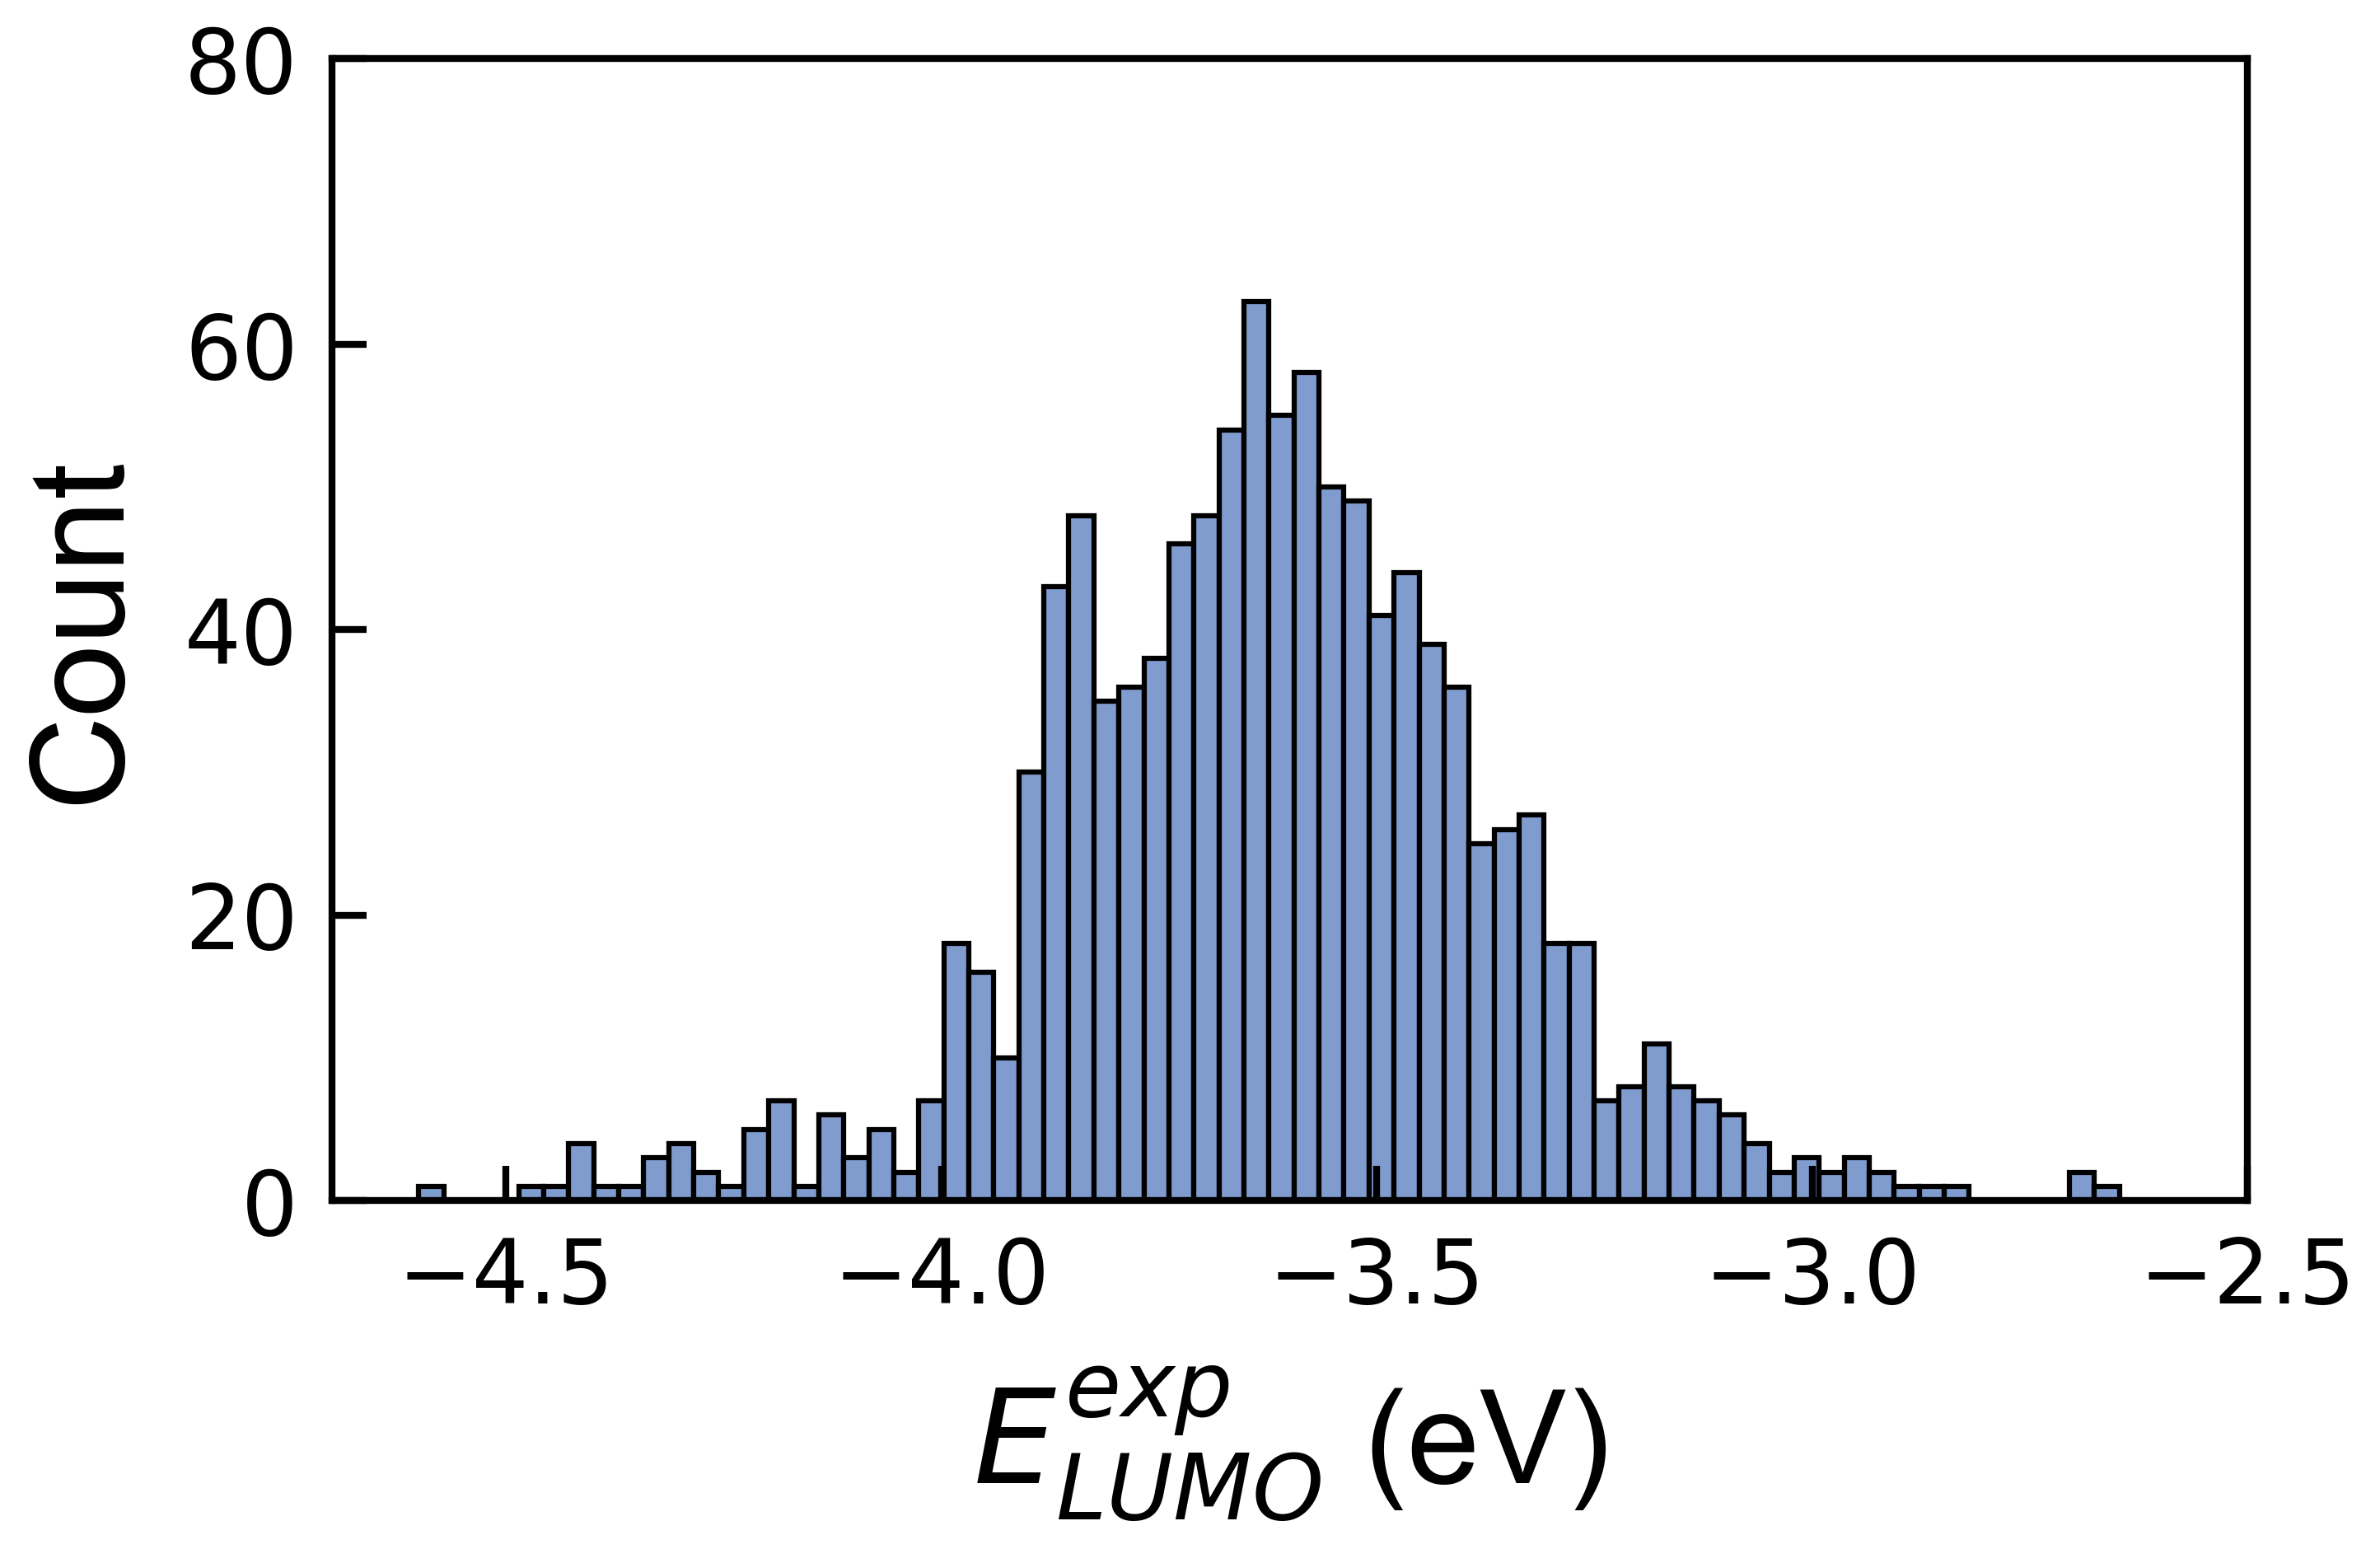

In [10]:
xticks=[-4.5,-4, -3.5, -3, -2.5]
yticks = [0, 20, 40, 60, 80]
yscale =[0, 80]
xlabel='$E_{LUMO}^{exp}$ (eV)'
hist_plot(df, 'LUMO(eV)', xticks, yticks, xlabel, yscale)

In [11]:
print('80% range:',df['LUMO(eV)'].quantile(0.1), df['LUMO(eV)'].quantile(0.9))

80% range: -3.9 -3.3099999999999996


# 3. bandgap distribution

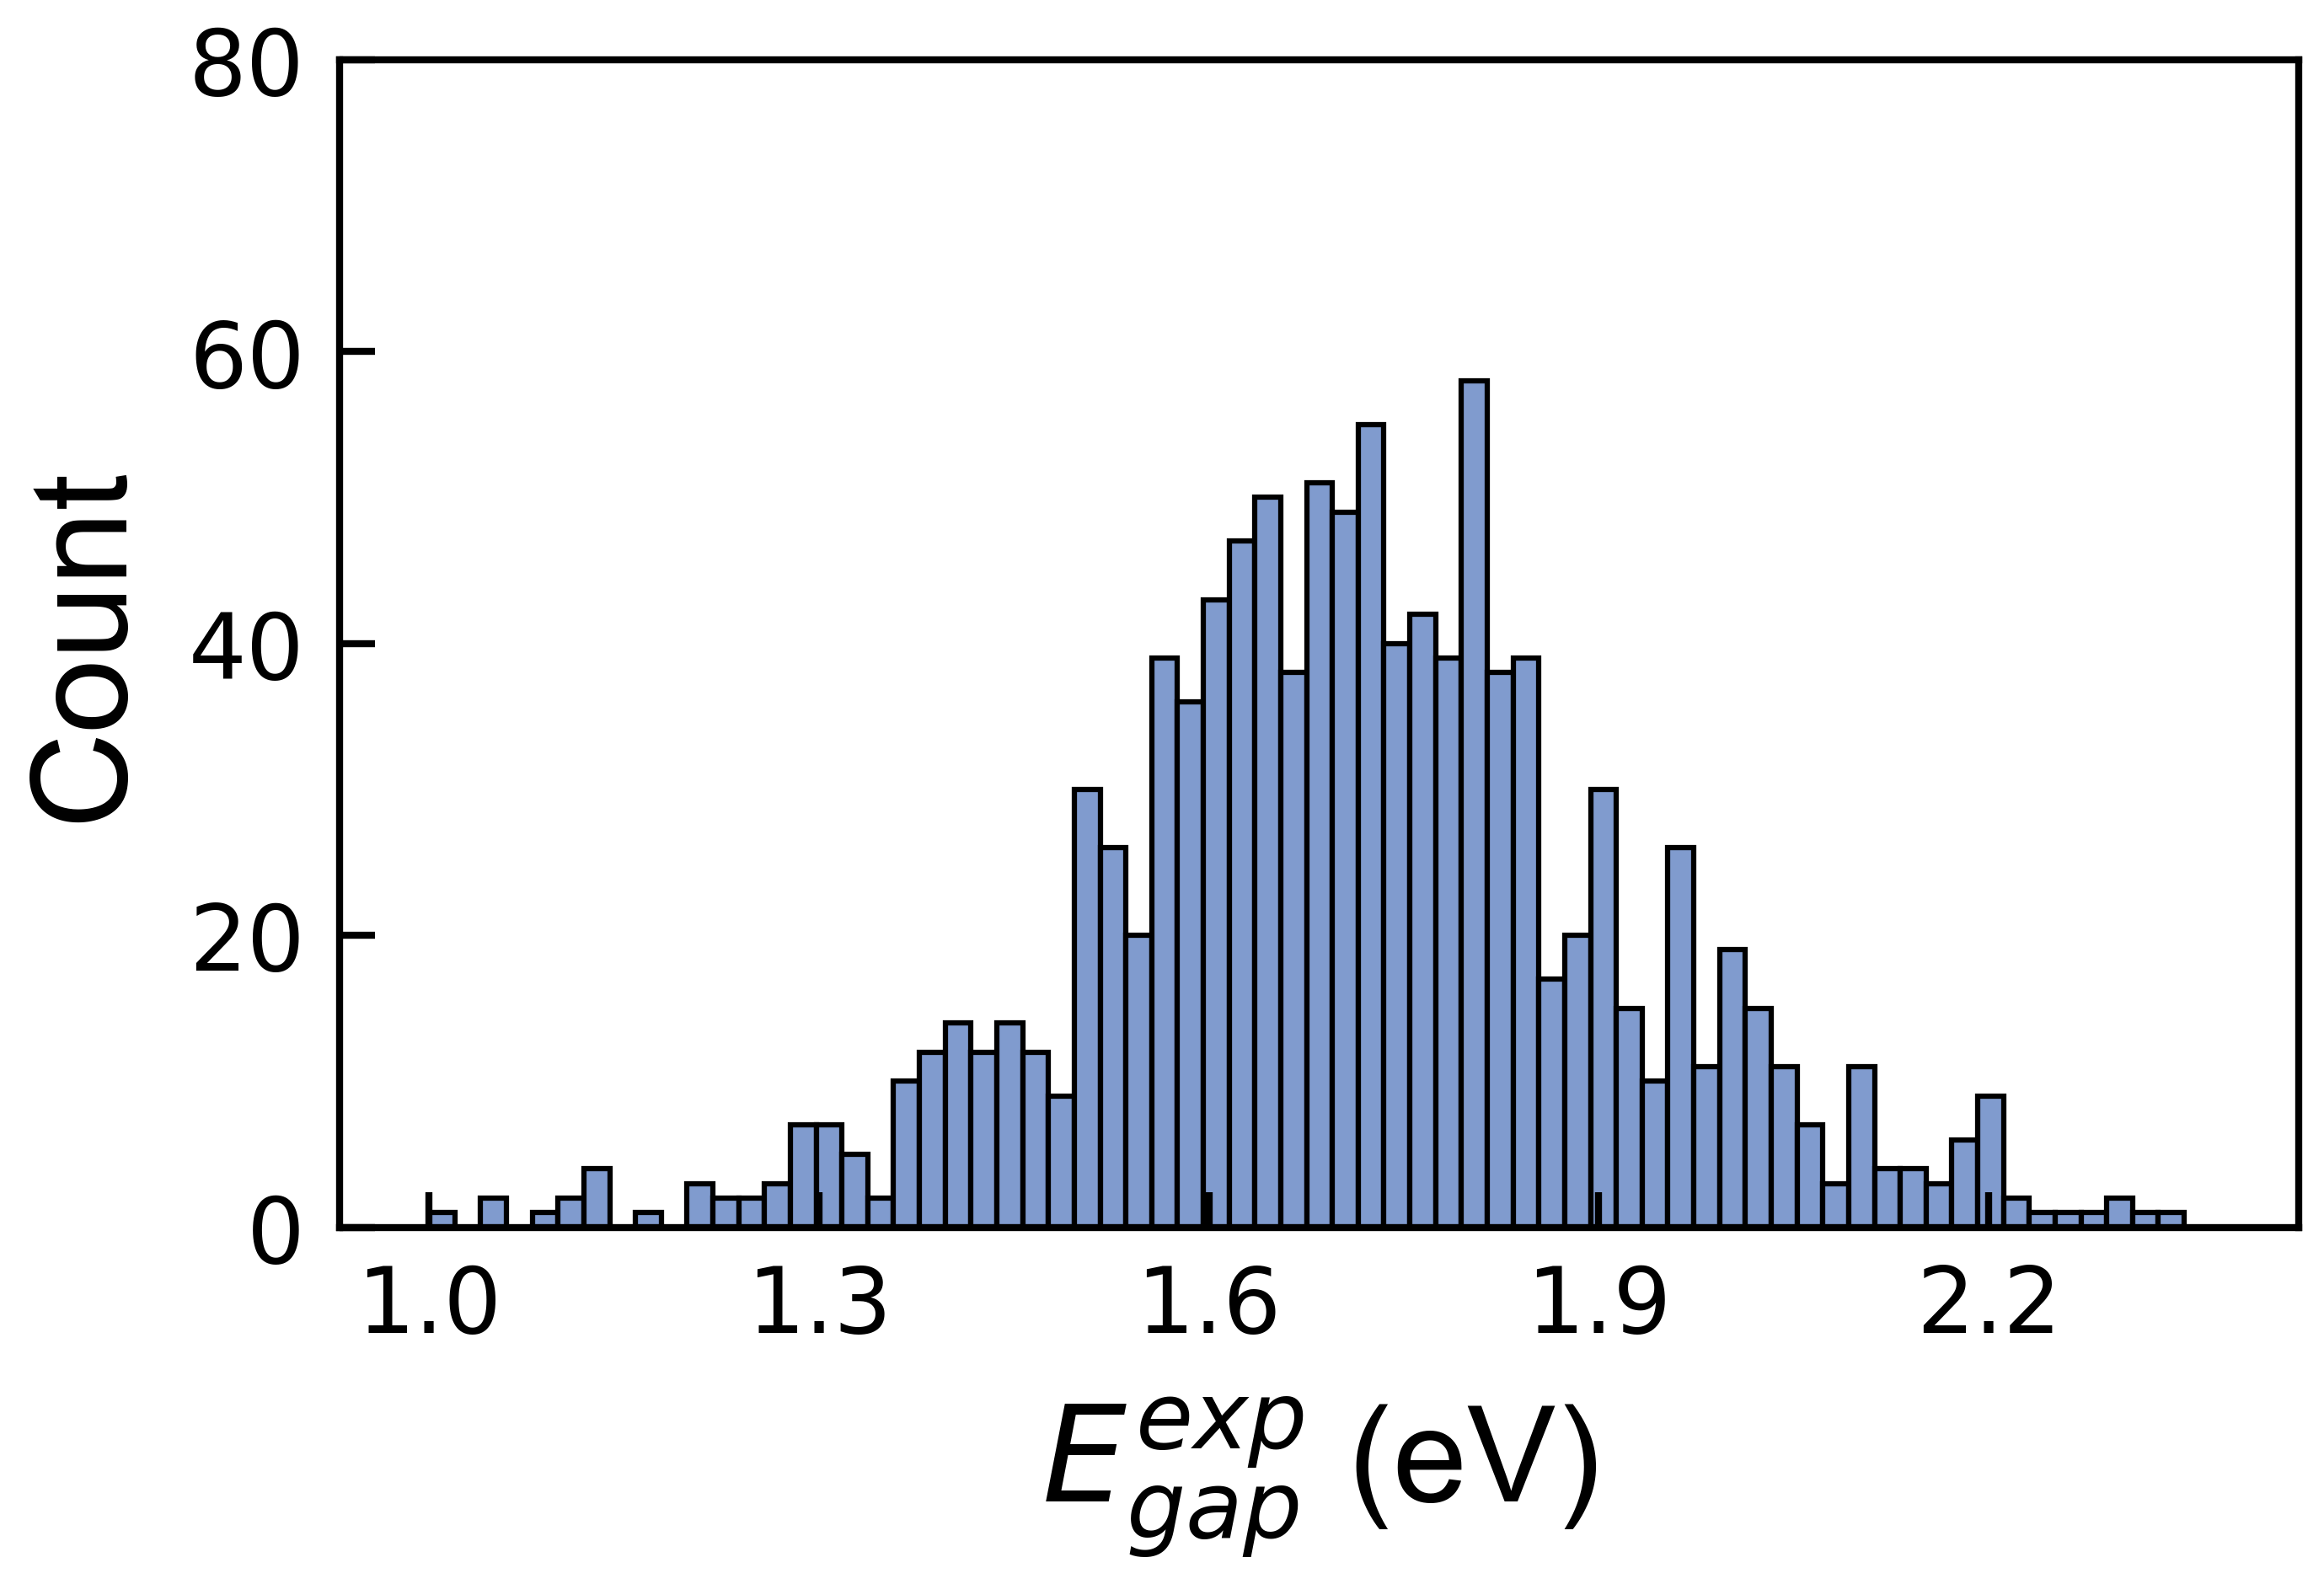

In [12]:
xticks=[1, 1.3, 1.6, 1.9, 2.2]
yticks = [0, 20, 40, 60, 80]
yscale =[0, 80]
xlabel='$E_{gap}^{exp}$ (eV)'
hist_plot(df, 'bandgap(eV)', xticks, yticks, xlabel, yscale)

In [13]:
print('80% range:',df['bandgap(eV)'].quantile(0.1), df['bandgap(eV)'].quantile(0.9))

80% range: 1.4649999999999999 1.98


In [14]:
df['bandgap(eV)'].describe()

count    1096.000000
mean        1.715839
std         0.205823
min         1.000000
25%         1.590000
50%         1.710000
75%         1.830000
max         2.390000
Name: bandgap(eV), dtype: float64

## 2. atom number distribution

In [15]:
monomer_list = df['c_smiles'].values
oligomer_list = df['newSMILES'].values


In [16]:
monomer_NO=[]
oligomer_NO=[]
for monomer, oligomer in zip(monomer_list, oligomer_list):
    monomer_mol = Chem.MolFromSmiles(monomer)
    monomer_mol_H = Chem.rdmolops.AddHs(monomer_mol)
    oligomer_mol = Chem.MolFromSmiles(oligomer)
    oligomer_mol_H = Chem.rdmolops.AddHs(oligomer_mol)
    
    monomer_NO.append(monomer_mol_H.GetNumAtoms())
    oligomer_NO.append(oligomer_mol_H.GetNumAtoms())

    
df['monomer_NO'] = monomer_NO
df['oligomer_NO'] = oligomer_NO
df

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No,HOMO(eV),LUMO(eV),monomer_NO,oligomer_NO
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10,-5.20,-3.27,33,68
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123,-4.90,-3.08,34,74
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126,-5.34,-3.58,49,110
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122,-5.15,-3.23,49,68
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122,-5.11,-3.22,56,62
...,...,...,...,...,...,...,...,...,...
1091,BTT-NTz,1.68,CCCCCCCCCCCCc1cc(C)sc1-c1cc2c3sc(C(CCCCCCCC)CC...,Cc1cc(C)c(s1)-c1cc2c3sc(C)cc3c3cc(sc3c2s1)-c1s...,S115,-5.41,-3.73,340,88
1092,PIDTI-BT,1.65,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1cc2n(C)c3cc4-c5cc6c(cc5C(c4cc3c2s1)(c1ccccc...,S441,-5.30,-3.65,349,214
1093,PIDTI-DTBT,1.66,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1ccc(s1)-c1ccc(-c2ccc(s2)-c2cc3n(C)c4cc5-c6c...,S441,-5.26,-3.60,363,125
1094,poly(DPP4T-alt-TBP),1.52,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)C2=C(c3ccc(-c...,CN1C(=O)C2=C(N(C)C(=O)C2=C1c1ccc(C)s1)c1ccc(s1...,S464,-5.42,-3.90,382,106


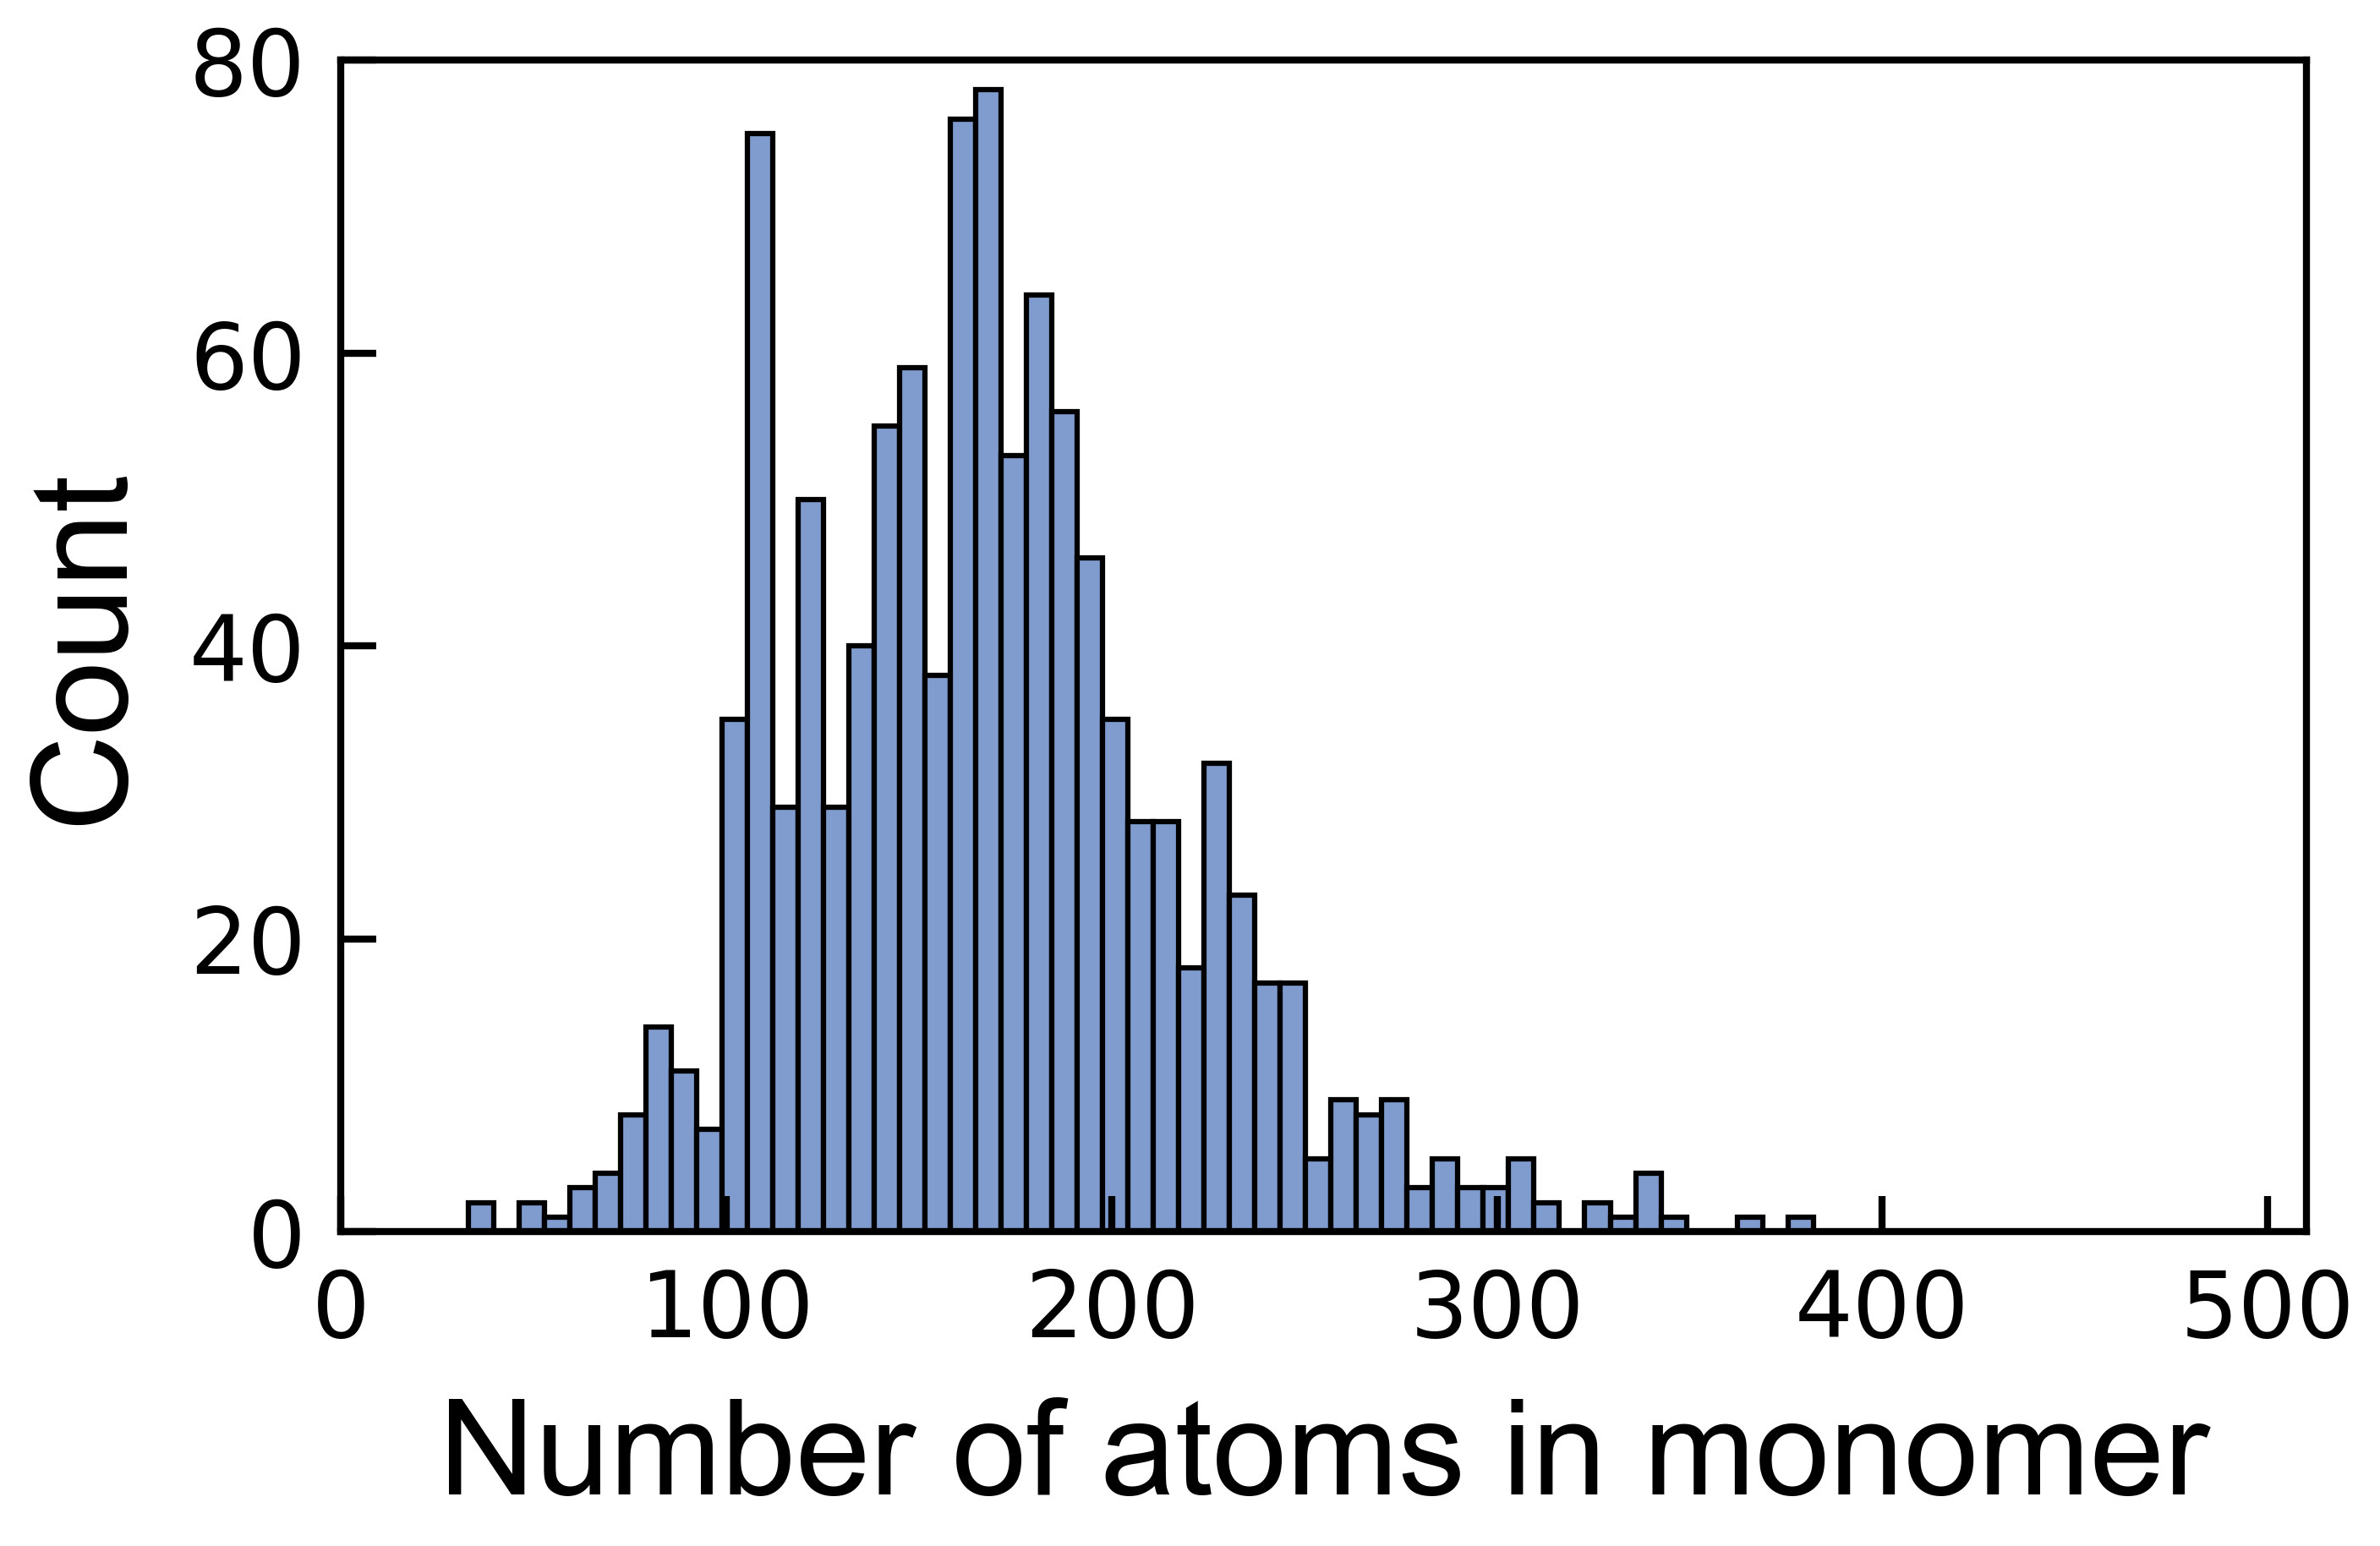

In [17]:
xticks=[0, 100, 200, 300, 400, 500]
yticks = [0, 20, 40, 60, 80]
yscale=[0,80]
xlabel='Number of atoms in monomer'
hist_plot(df, 'monomer_NO', xticks, yticks, xlabel, yscale)

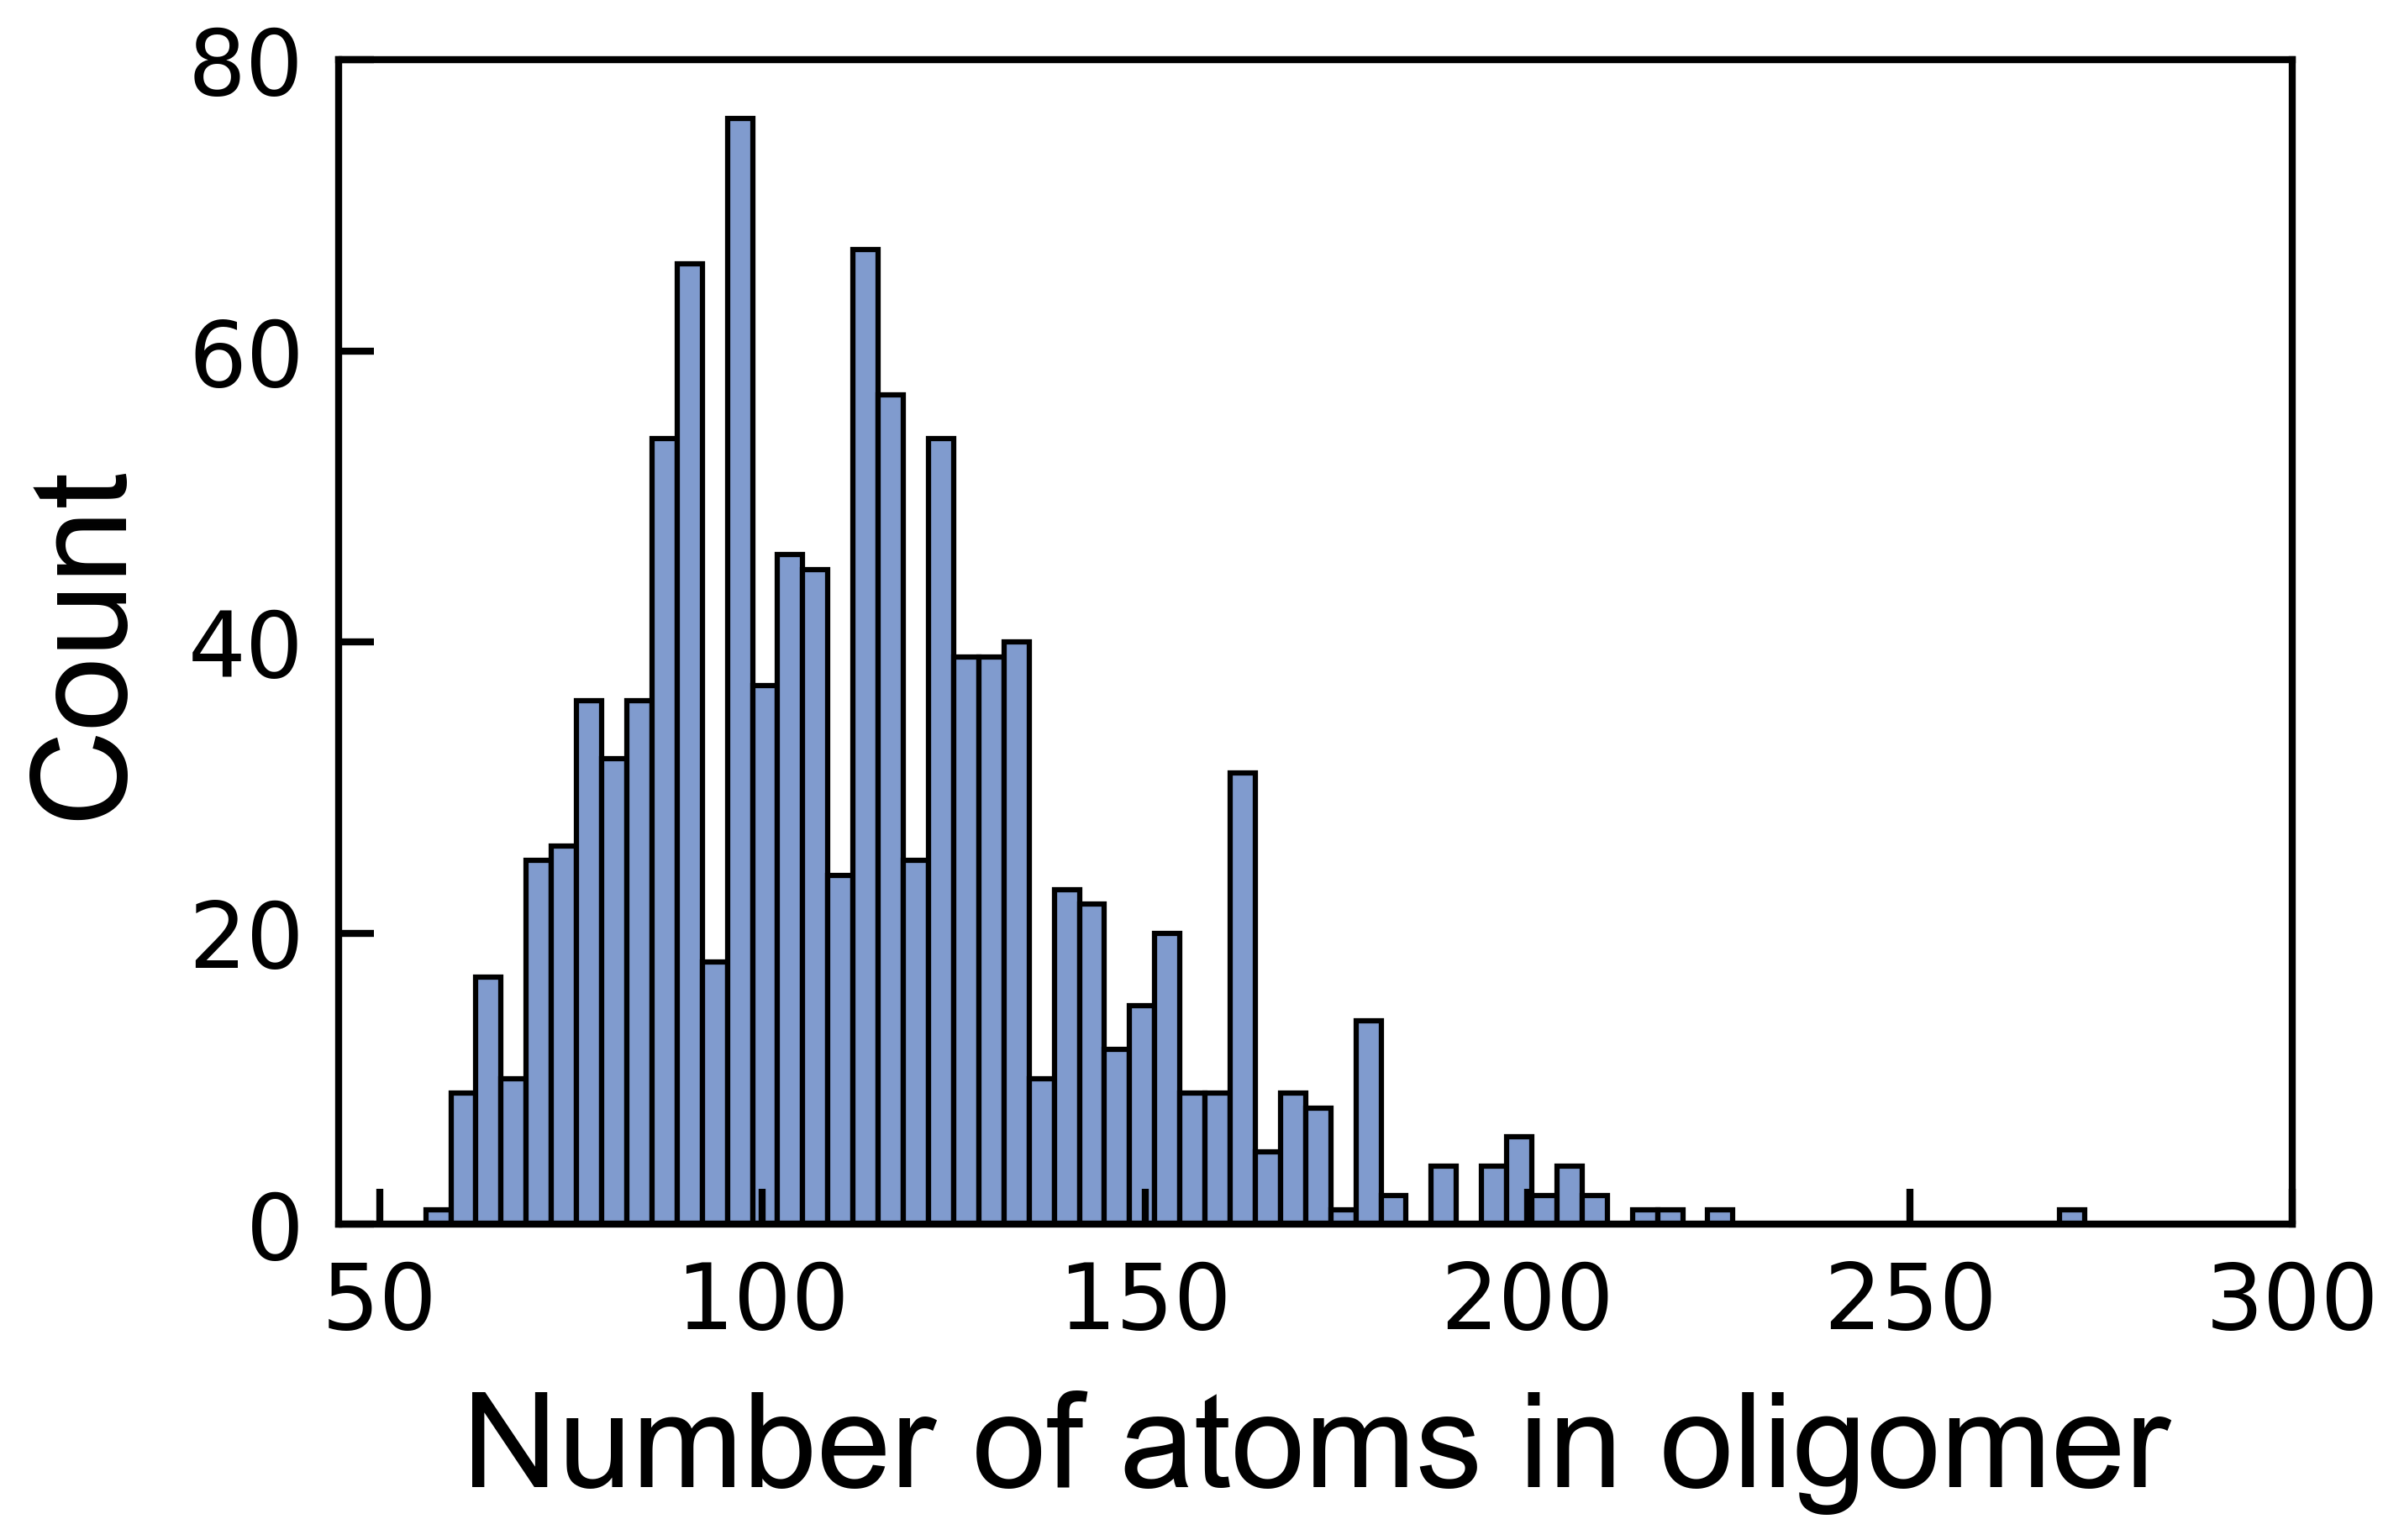

In [18]:
xticks=[50, 100, 150, 200, 250, 300]
yticks = [0, 20, 40, 60, 80]
yscale=[0,80]
xlabel='Number of atoms in oligomer'
hist_plot(df, 'oligomer_NO', xticks, yticks, xlabel, yscale)

In [19]:
df.describe()

,bandgap(eV),HOMO(eV),LUMO(eV),monomer_NO,oligomer_NO
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,1.715839,-5.333759,-3.617920,168.406934,113.491788
std,0.205823,0.224913,0.256235,51.459578,30.915202
min,1.000000,-6.180000,-4.600000,33.000000,56.000000
25%,1.590000,-5.470000,-3.780000,132.750000,90.000000
50%,1.710000,-5.340000,-3.620000,166.000000,110.000000
75%,1.830000,-5.200000,-3.460000,196.000000,130.000000
max,2.390000,-4.240000,-2.590000,494.000000,286.000000


In [20]:
print('80% range:',df['monomer_NO'].quantile(0.1), df['monomer_NO'].quantile(0.9))

80% range: 107.5 232.0


In [21]:
print('80% range:',df['oligomer_NO'].quantile(0.1), df['oligomer_NO'].quantile(0.9))

80% range: 78.0 156.0


# Plot two histograms on single chart

In [22]:
df

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No,HOMO(eV),LUMO(eV),monomer_NO,oligomer_NO
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10,-5.20,-3.27,33,68
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123,-4.90,-3.08,34,74
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126,-5.34,-3.58,49,110
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122,-5.15,-3.23,49,68
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122,-5.11,-3.22,56,62
...,...,...,...,...,...,...,...,...,...
1091,BTT-NTz,1.68,CCCCCCCCCCCCc1cc(C)sc1-c1cc2c3sc(C(CCCCCCCC)CC...,Cc1cc(C)c(s1)-c1cc2c3sc(C)cc3c3cc(sc3c2s1)-c1s...,S115,-5.41,-3.73,340,88
1092,PIDTI-BT,1.65,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1cc2n(C)c3cc4-c5cc6c(cc5C(c4cc3c2s1)(c1ccccc...,S441,-5.30,-3.65,349,214
1093,PIDTI-DTBT,1.66,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1ccc(s1)-c1ccc(-c2ccc(s2)-c2cc3n(C)c4cc5-c6c...,S441,-5.26,-3.60,363,125
1094,poly(DPP4T-alt-TBP),1.52,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)C2=C(c3ccc(-c...,CN1C(=O)C2=C(N(C)C(=O)C2=C1c1ccc(C)s1)c1ccc(s1...,S464,-5.42,-3.90,382,106


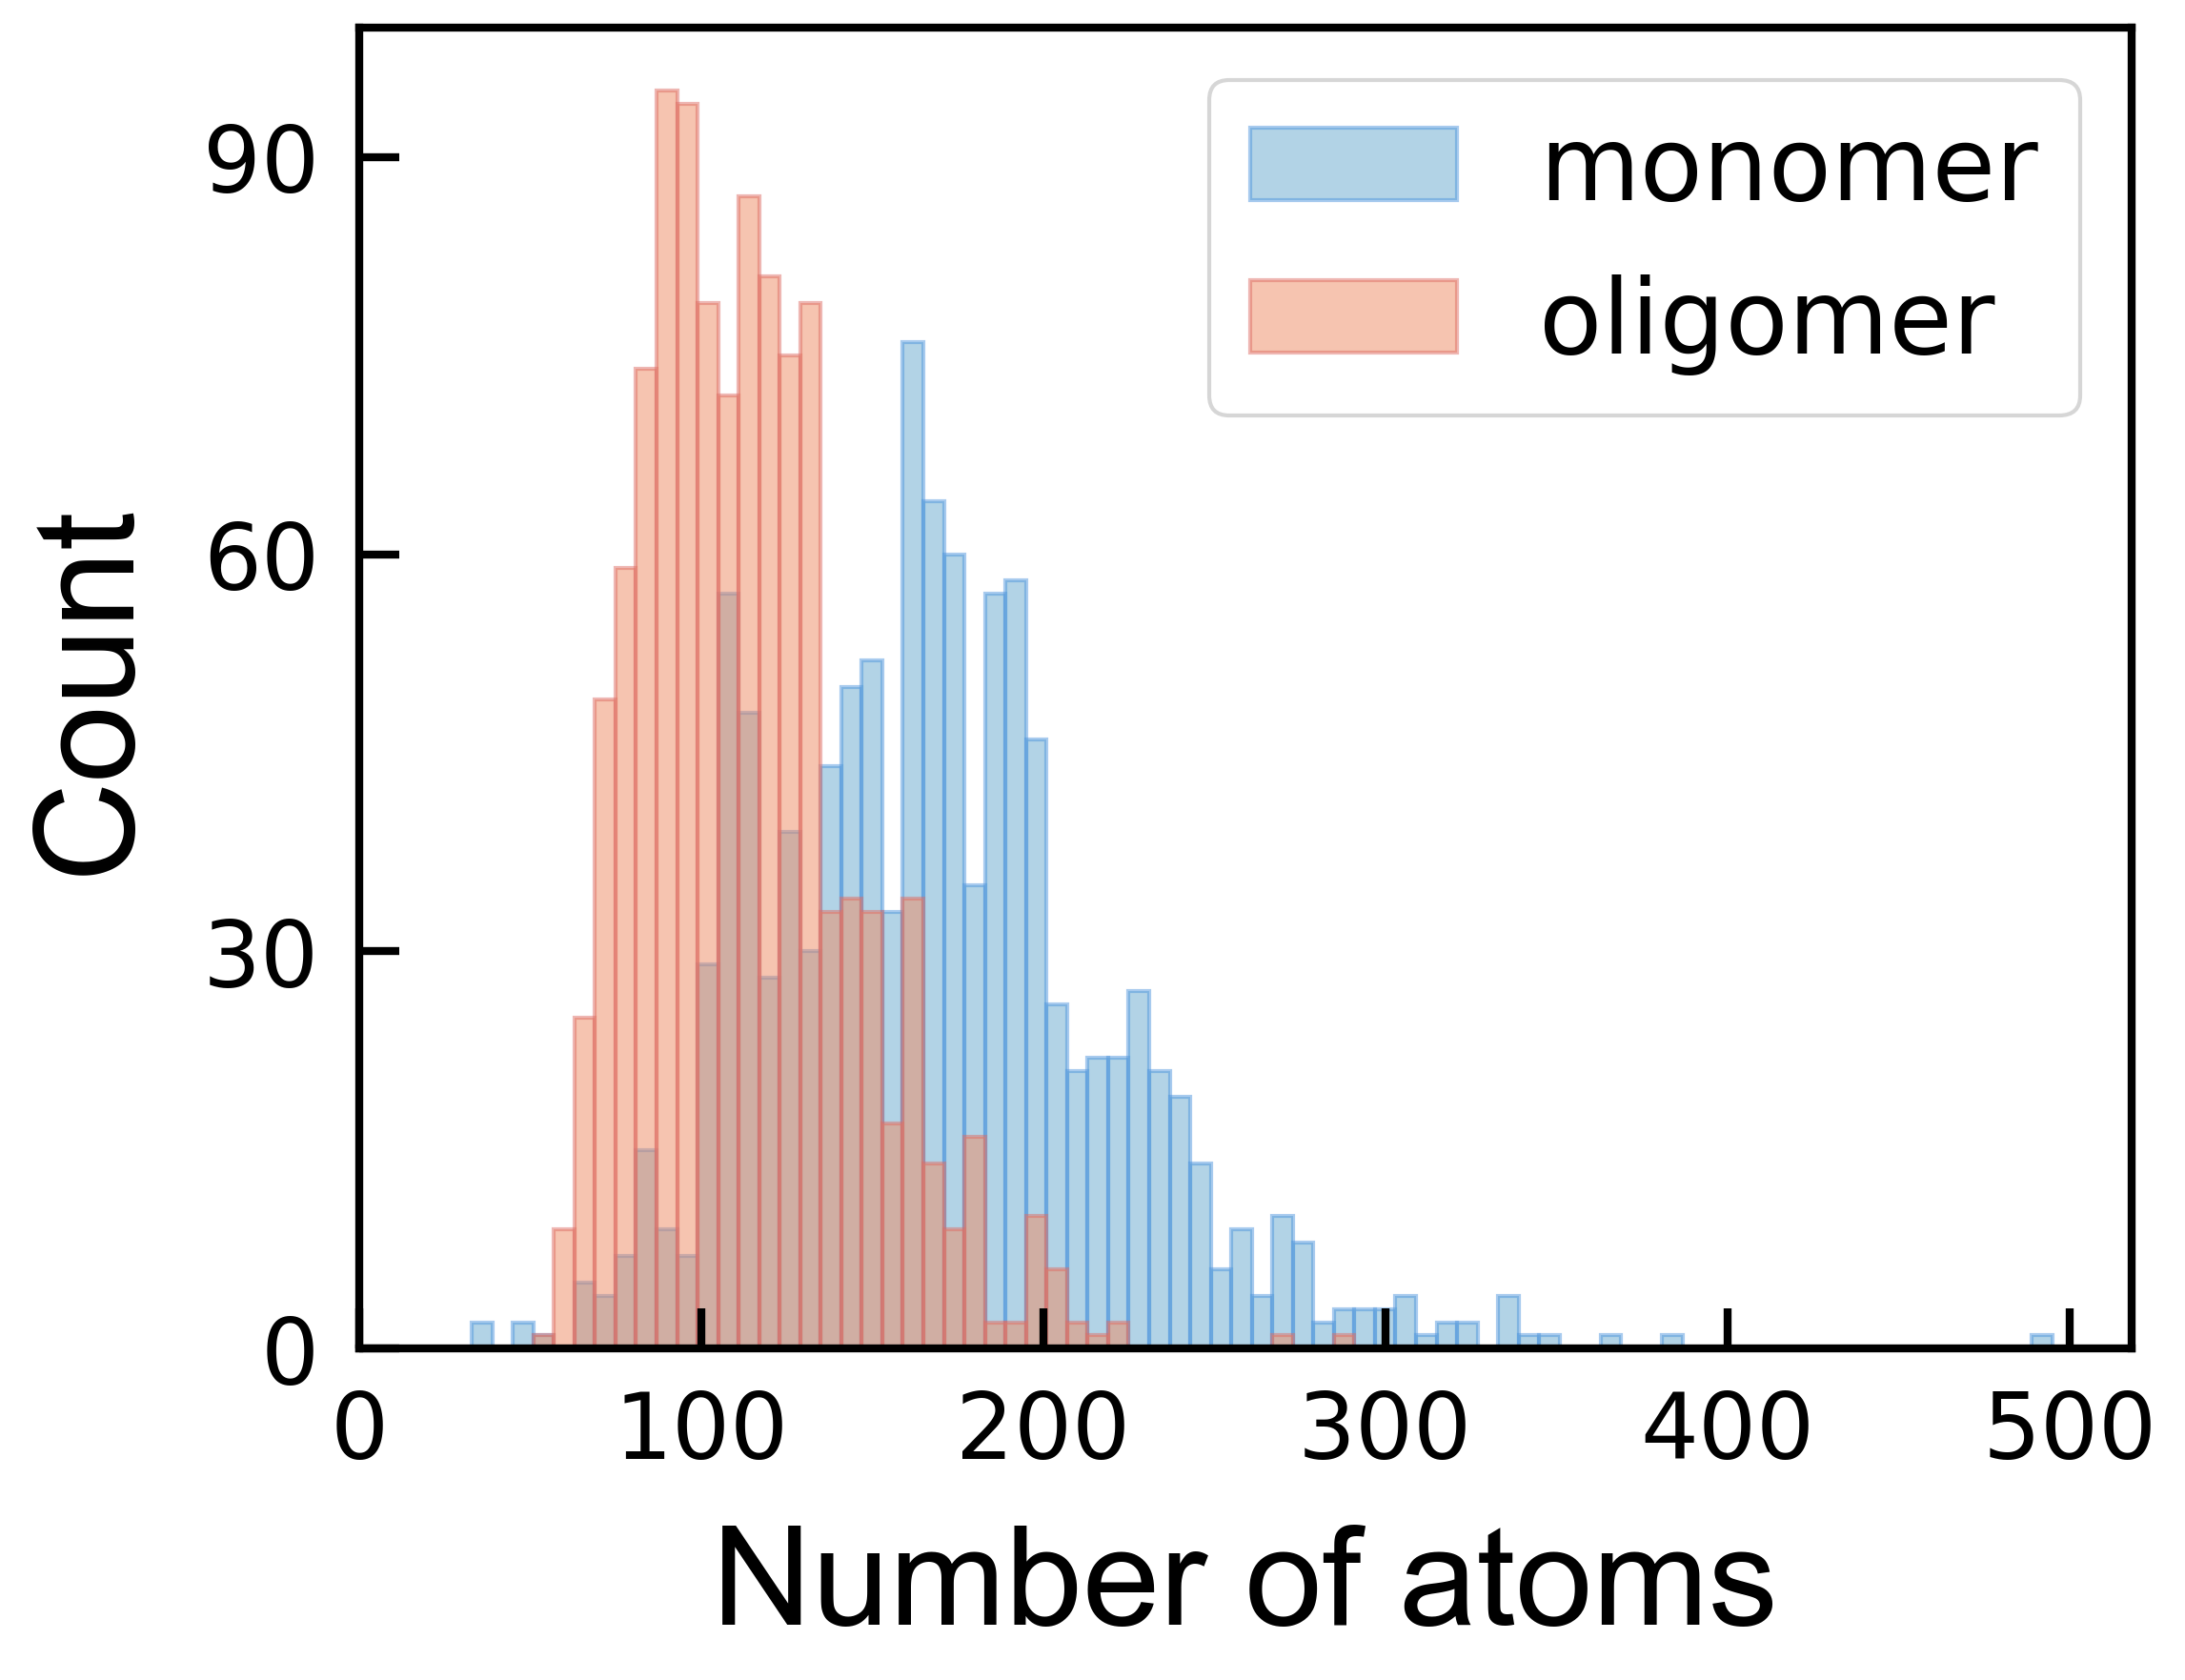

In [28]:
fig, ax = plt.subplots(figsize=(8,6), dpi=300)

colors = ['#ef8a62', '#67a9cf']
# 计算两个数据集的总范围
data_min = min(df['monomer_NO'].min(), df['oligomer_NO'].min())
data_max = max(df['monomer_NO'].max(), df['oligomer_NO'].max())

# 设置柱状的固定宽度
bin_width = 6
bins = np.arange(data_min, data_max + bin_width, bin_width)

# plt.hist(df['monomer_NO'], bins=bins, alpha=0.5, label='monomer', edgecolor='black', linewidth=1, color='blue')
# plt.hist(df['oligomer_NO'], bins=bins, alpha=0.5, label='oligomer', edgecolor='black', linewidth=1, color='red')

plt.hist(df['monomer_NO'], bins=bins, alpha=0.5, label='monomer',edgecolor='#5096DE', linewidth=1, color=colors[1])
plt.hist(df['oligomer_NO'], bins=bins, alpha=0.5, label='oligomer',edgecolor='#DE6E66', linewidth=1,color=colors[0])
plt.legend(fontsize=26)


ax.tick_params(direction='in', width=2)
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)

for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Number of atoms', fontsize=35, font="arial", labelpad=12)
plt.ylabel('Count', fontsize=35, font="arial", labelpad=12)

xticks = [0, 100, 200, 300, 400, 500]
yticks = [0, 30, 60, 90]
plt.xticks(xticks, fontsize=23)
plt.yticks(yticks, fontsize=23)
plt.gca().tick_params(axis='both', length=10, width=2)

#     plt.xlim(data_min, data_min)
# plt.ylim(yscale[0], yscale[1])
plt.show()